# Imports

In [1]:
import h5py
import os
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading nifti images
import math
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from read_data import load_images
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Dependencies

In [2]:
import tensorflow as tf
import keras
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Tensorflow version: 1.5.0
Keras version: 2.2.4


---

# Data Preprocessing
Prepare data for input and data preprocessing

Plot data w.r.t labels

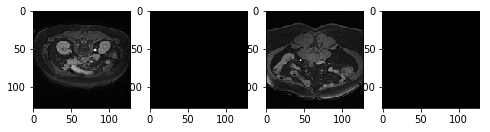

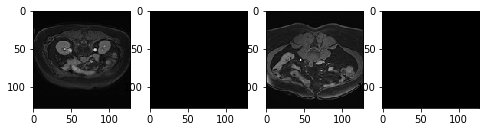

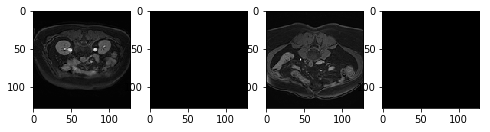

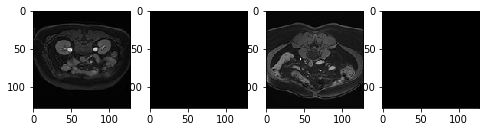

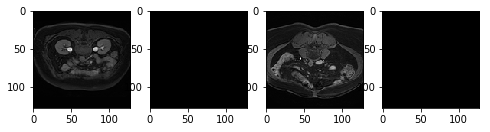

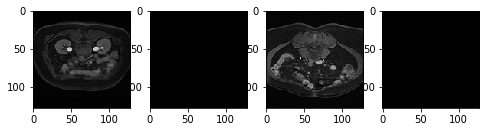

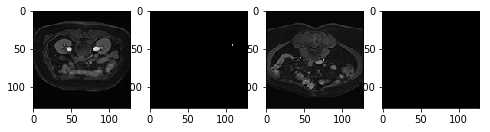

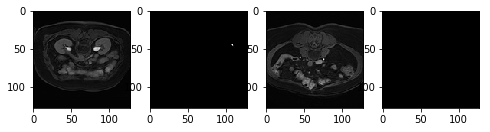

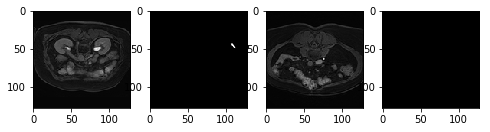

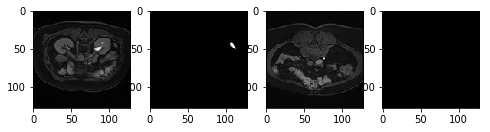

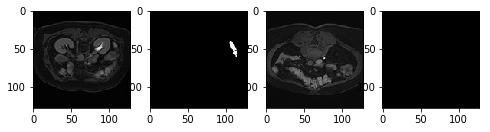

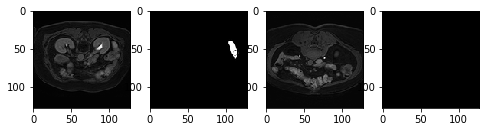

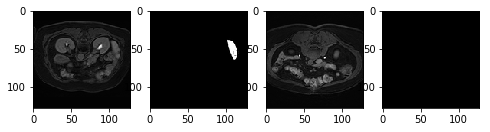

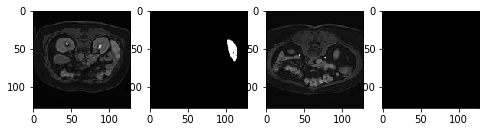

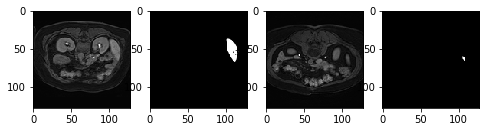

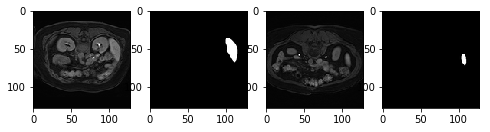

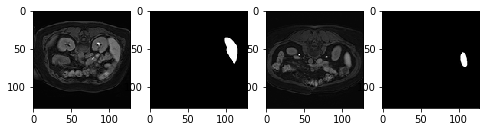

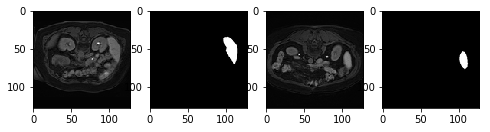

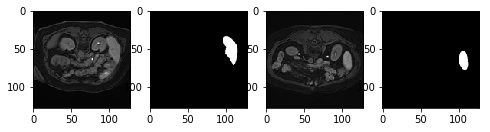

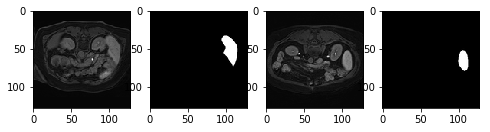

In [3]:
#show 1st 20 slices

#training data
x_data = np.load('x_data.npy')
y_data = np.load('y_data.npy')

#test data
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

for i in range(20):
    fig, ax = plt.subplots(1,4, figsize = (8,4))
    ax[0].imshow(x_data[i], cmap='gray')
    ax[1].imshow(y_data[i], cmap='gray')
    ax[2].imshow(x_test[i], cmap='gray')
    ax[3].imshow(y_test[i], cmap='gray')
    
plt.show()

Reshape input data to feed into the network with 
shape (depth*#image, width, height, channel)

In [4]:
x_data = x_data[:,:,:,np.newaxis] # same as reshape (-1,128,128,1)
y_data = y_data[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]
y_test = y_test[:,:,:,np.newaxis]

print('Dimension for training data:', x_data.shape)
print('Dimension for training data labels:', y_data.shape)
print('Dimension for test data:', x_test.shape)
print('Dimension for test data labels:', y_test.shape)

Dimension for training data: (3036, 128, 128, 1)
Dimension for training data labels: (3036, 128, 128, 1)
Dimension for test data: (735, 128, 128, 1)
Dimension for test data labels: (735, 128, 128, 1)


Split data: 80% Training, 20% Validation

In [5]:
from sklearn.utils import shuffle
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, random_state = 42)
x_test, y_test = shuffle(x_test, y_test, random_state = 42)

Approximation of Dice Coefficient

In [6]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [7]:
input_layer = Input(shape=x_train.shape[1:]) #Input(shape = (x, y, inChannel))

---

# Network Topology

In [10]:
def conv_block(x_in, filters, batch_norm, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_2d(x_in, filters, batch_norm, kernel_size=(3,3),acti ='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x=BatchNormalization()(x)
    x= Activation(acti)(x)
    return x
    
def pool(x_in, pool_size=(2, 2), type='Max'):
    if type=='Max':
        p = MaxPooling2D(pool_size)(x_in)
    return p

def up(x_in, filters, merge, batch_norm, size=(2,2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_block(u, filters, batch_norm)
    merge=concatenate([merge, conv],axis=-1)
    return merge
    
def Unet_05(input_layer):
    conv1 = conv_block(input_layer, filters=16, batch_norm='TRUE')
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=32, batch_norm='TRUE')
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=32, batch_norm='TRUE')
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=64, batch_norm='TRUE')
    pool4 = pool(conv4)
    
    conv5 = conv_2d(pool4, filters=128, batch_norm='TRUE')
    
    up1 = up(conv5,filters=128, merge=conv4, batch_norm='TRUE')
    conv6 = conv_2d(up1, filters=128, batch_norm='TRUE')
    
    up2 = up(conv6, filters=128, merge=conv3, batch_norm='TRUE')
    conv7 = conv_2d(up2, filters=128, batch_norm='TRUE')
    
    up3 = up(conv7, filters=64, merge=conv2, batch_norm='TRUE')
    conv8 = conv_2d(up3, filters=64, batch_norm='TRUE')
    
    up4 = up(conv8, filters=32, merge=conv1, batch_norm='TRUE')
    conv9 = conv_2d(up4, filters=32, batch_norm='TRUE')
    
    conv10 = conv_2d(conv9, filters=1, batch_norm='FALSE', acti='sigmoid')
    
    output_layer = conv10
    model = Model(input_layer, output_layer)
    
    return model
    

Swtich for different network

In [13]:
model = Unet_05(input_layer)

Data Augmentation

In [14]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=42)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=42)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

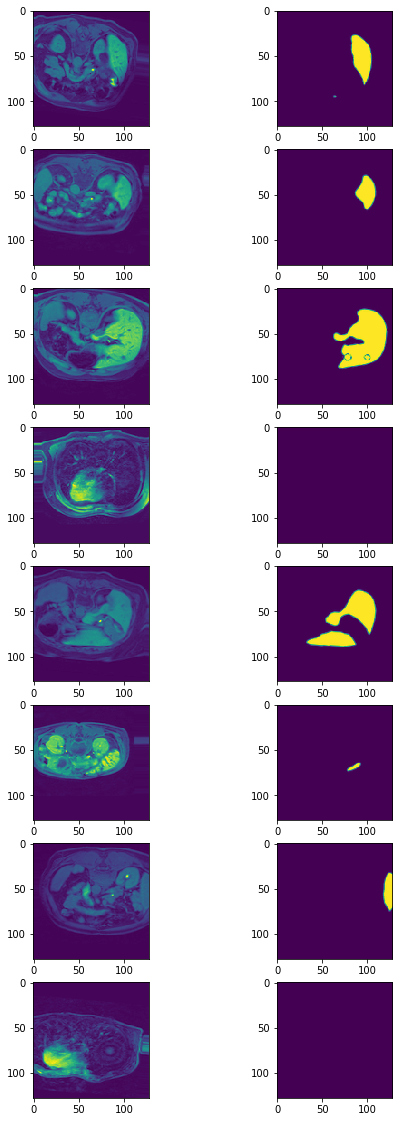

In [15]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [16]:
model.compile(optimizer=Adam(1e-4), loss= dice_coef_loss, metrics=[dice_coef])

Set checkpoint

In [17]:
from keras.callbacks import LearningRateScheduler
import time 

write_time = time.strftime("%H"+"%M")

weight_saver = ModelCheckpoint('chck_pt/seg_{}.h5'.format(write_time), monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

Parameters

In [18]:
batch_size = 64
epochs = 20

In [19]:
from keras.callbacks import TensorBoard

model_dir = 'logs/{}'.format(write_time)
tensorboard = TensorBoard(log_dir= model_dir, histogram_freq=epochs, batch_size=batch_size, write_graph=True, 
                          write_grads=True, write_images=True, embeddings_freq=0, 
                          embeddings_layer_names=None, embeddings_metadata=None, 
                          embeddings_data=None, update_freq='epoch')

In [20]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model_json/model_{}.json".format(write_time), "w") as json_file:
    json_file.write(model_json)
    
print('The write time for this run is:', write_time) #trackback for tensorboard, model_json,weight file

The write time for this run is: 1549


---

# Training

In [21]:
hist = model.fit_generator(my_generator(x_train, y_train, batch_size),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=epochs, verbose=1,
                           callbacks = [weight_saver, annealer])

Epoch 1/20
200/200 [==============================] - 65s 323ms/step - loss: 0.1357 - dice_coef: 0.8643 - val_loss: 0.3401 - val_dice_coef: 0.6599
Epoch 2/20
200/200 [==============================] - 60s 300ms/step - loss: 0.0535 - dice_coef: 0.9465 - val_loss: 0.1229 - val_dice_coef: 0.8771
Epoch 3/20
200/200 [==============================] - 62s 309ms/step - loss: 0.0468 - dice_coef: 0.9532 - val_loss: 0.1211 - val_dice_coef: 0.8789
Epoch 4/20
200/200 [==============================] - 60s 300ms/step - loss: 0.0424 - dice_coef: 0.9576 - val_loss: 0.0918 - val_dice_coef: 0.9082
Epoch 5/20
200/200 [==============================] - 61s 306ms/step - loss: 0.0398 - dice_coef: 0.9602 - val_loss: 0.0353 - val_dice_coef: 0.9647
Epoch 6/20
200/200 [==============================] - 62s 311ms/step - loss: 0.0385 - dice_coef: 0.9615 - val_loss: 0.0394 - val_dice_coef: 0.9606
Epoch 7/20
200/200 [==============================] - 58s 292ms/step - loss: 0.0377 - dice_coef: 0.9623 - val_loss: 0.

To resume the model instead of running the entire model again 

In [22]:
# json_file = open("model_json/model_{}.json".format(write_time), 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# model = loaded_model

In [23]:
model.load_weights('chck_pt/seg_{}.h5'.format(write_time))

---

# Results  

Learning Rate Plot

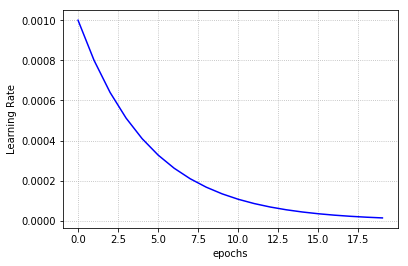

In [24]:
plt.plot(hist.history['lr'], color='b')
plt.xlabel("epochs")
plt.ylabel("Learning Rate")
plt.grid(linestyle='dotted')
plt.show()

***

Loss and Dice Coefficient Plot

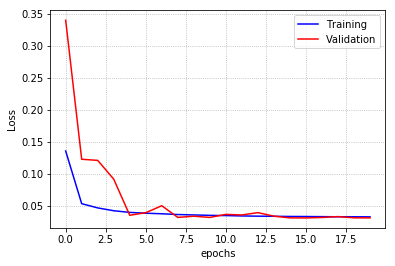

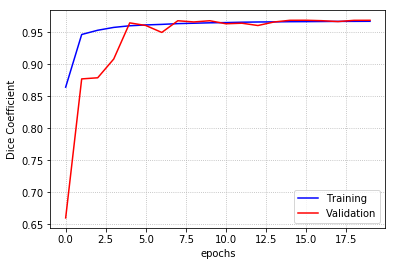

In [25]:
plt.plot(hist.history['loss'], color='b', label='Training')
plt.plot(hist.history['val_loss'], color='r', label='Validation')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid(linestyle='dotted')
plt.show()

plt.plot(hist.history['dice_coef'], color='b', label='Training')
plt.plot(hist.history['val_dice_coef'], color='r', label='Validation')
plt.xlabel("epochs")
plt.ylabel("Dice Coefficient")
plt.legend(loc='lower right')
plt.grid(linestyle='dotted')
plt.show()

In [26]:
# To run tensorboard
print('To view tensorboard, put this in your command line: \n tensorboard --log=logs/{}/'.format(write_time))

To view tensorboard, put this in your command line: 
 tensorboard --log=logs/1549/


In [27]:
test_eval = model.evaluate(x_test, y_test, verbose=1, batch_size = batch_size)

735/735 [==============================] - 2s 2ms/step


In [28]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.06995605952074739
Test accuracy: 0.9300439404792527


---

# Prediction

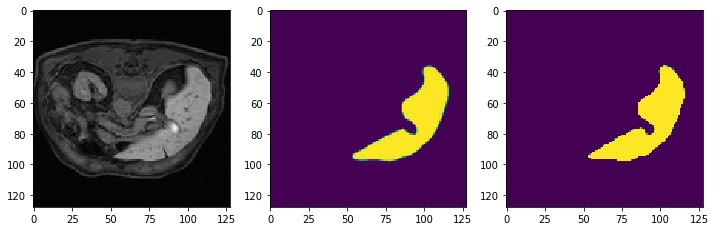

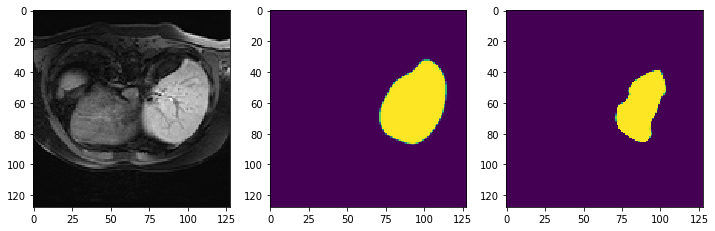

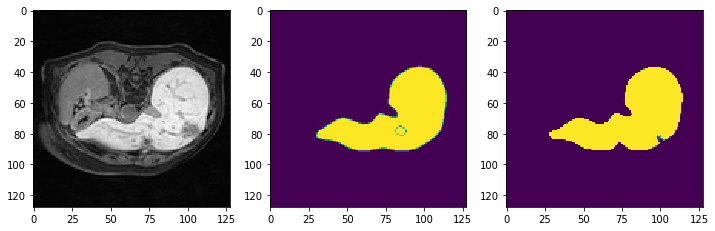

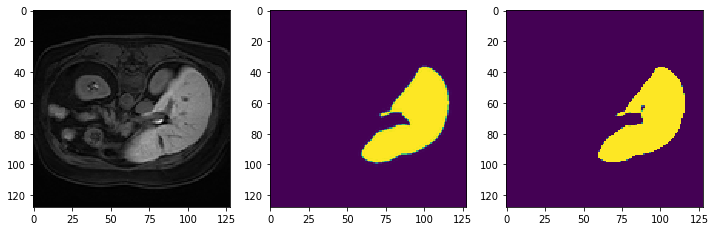

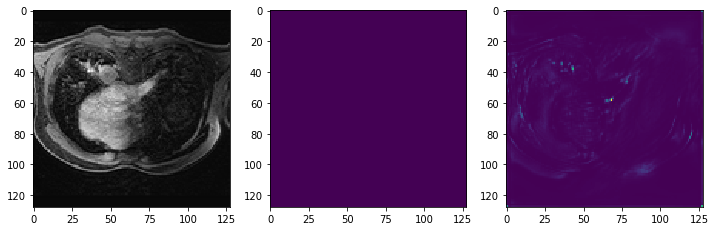

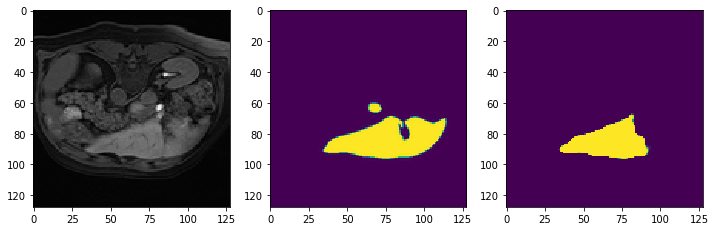

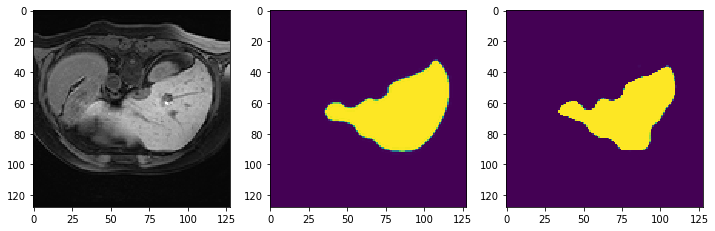

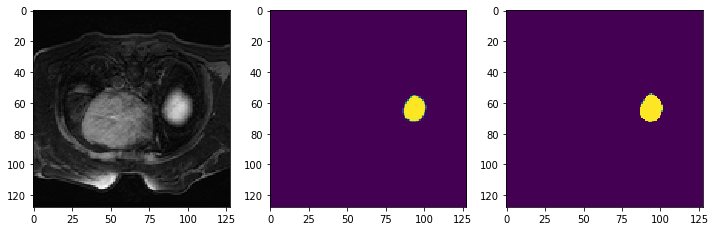

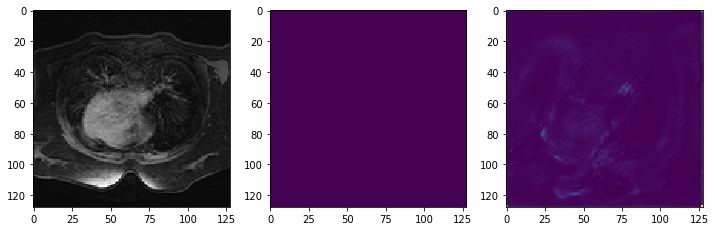

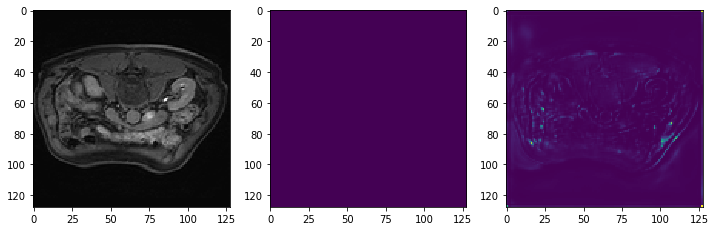

In [29]:
y_pred = model.predict(x_test)
for i in range(0,20,2):
    fig, ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].imshow(x_test[i,:,:,0], cmap='gray')
    ax[1].imshow(y_test[i,:,:,0])
    ax[2].imshow(y_pred[i,:,:,0])
plt.show()

---

# Appendix

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

# Reference

https://www.kaggle.com/toregil/a-lung-u-net-in-keras 

https://github.com/jocicmarko/ultrasound-nerve-segmentation